In [20]:
import sys
sys.path.append('..')

import time
from src.pdfs_numba_stats import SignalBackgroundModel
import numba_stats
import scipy.stats as stats
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('mystyle.mplstyle')
np.random.seed(42)

## Compare the performance of scipy.stats and numba-stats

In [21]:
size = 10000000
data = np.random.randn(size)

# Using scipy.stats
start = time.time()
pdf_scipy = stats.norm.pdf(data, loc=0, scale=1)
end = time.time()
print(f"scipy.stats time: {end - start:.4f} seconds")

# Using numba-stats
start = time.time()
pdf_numba = numba_stats.norm.pdf(data, loc=0, scale=1)
end = time.time()
print(f"numba-stats time: {end - start:.4f} seconds")

scipy.stats time: 0.1311 seconds
numba-stats time: 0.0869 seconds


## Generate sample



In [22]:
# Parameters
signal_params = {
    'mu': 3, 
    'sigma': 0.3, 
    'beta': 1, 
    'm': 1.4, 
    'decay_rate': 0.3
}
background_params = {
    'mu_bg': 0, 
    'sigma_bg': 2.5
}
f = 0.6  # Signal fraction
x_min, x_max = 0.0, 5.0
y_min, y_max = 0.0, 10.0

# Create model
model = SignalBackgroundModel(*signal_params.values(), *background_params.values(), f, x_min, x_max, y_min, y_max)

### Accept-reject sampling

In [23]:
# Get the maximum of the pdf
f_max_1 = np.max(model.pdf(np.linspace(x_min, x_max, 1000000), np.linspace(y_min, y_max, 1000000))) # Grid search
f_max_2 = -minimize(lambda x: -model.pdf(x[0], x[1]), [3, 0]).fun
f_max_3 = model.pdf(3.0, 0.0)
print(f_max_1, f_max_2, f_max_3)

0.03394304642768964 0.21804724535029033 0.21804724535029033


In [24]:
def accept_reject_sampling_2d(
        pdf, 
        n_samples: int, 
        x_min: float, x_max: float, 
        y_min: float, y_max: float, 
        f_max: float, 
        random_state: np.random.RandomState = np.random.RandomState(42)
    ):
    # Preallocate space for samples
    samples = np.zeros((n_samples, 2))
    count = 0  # Track the number of accepted samples

    # Generate samples in batches
    batch_size = int(2 * n_samples)  # Choose an appropriate batch size
    while count < n_samples:
        # Generate a batch of candidate points
        x = np.random.uniform(low=x_min, high=x_max, size=batch_size)
        y = np.random.uniform(low=y_min, high=y_max, size=batch_size)
        u = np.random.uniform(low=0, high=f_max, size=batch_size)

        # Evaluate the PDF
        pdf_values = pdf(x, y)

        # Accept samples
        accepted = u < pdf_values
        n_accepted = np.sum(accepted)

        # Limit the number of accepted samples to the remaining capacity
        remaining_capacity = n_samples - count
        n_to_add = min(n_accepted, remaining_capacity)

        # Add only as many samples as fit in the remaining capacity
        samples[count:count + n_to_add] = np.column_stack((x[accepted], y[accepted]))[:n_to_add]
        count += n_to_add

    return samples[:n_samples]

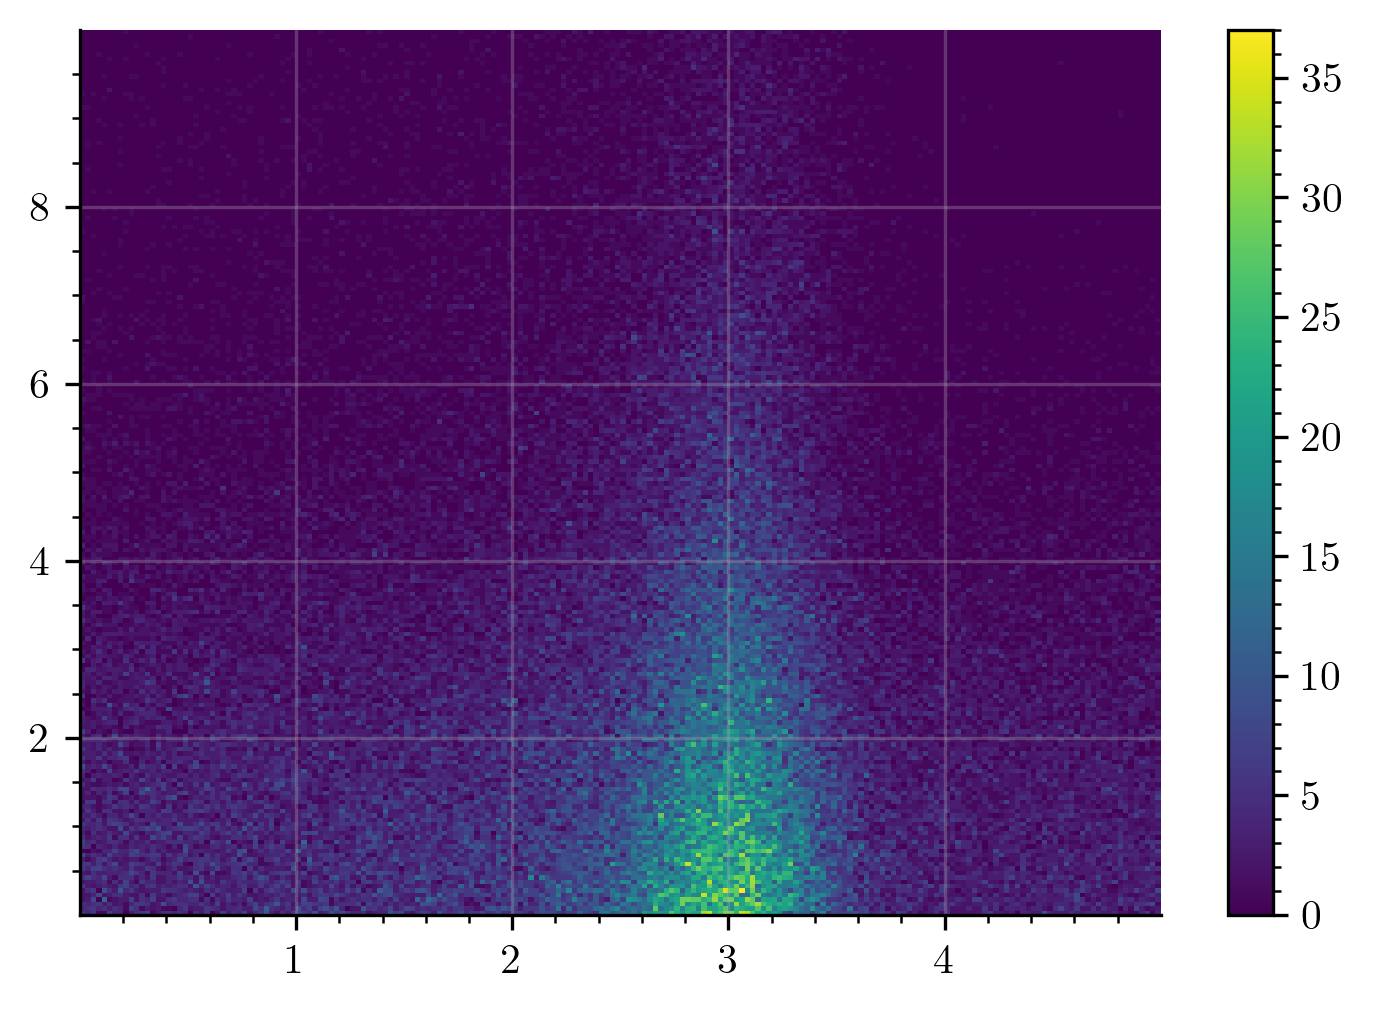

In [25]:
samples = accept_reject_sampling_2d(model.pdf, 100000, x_min, x_max, y_min, y_max, f_max_3)

# Save the samples
np.save('samples.npy', samples)

# Plot
x_samples, y_samples = samples[:, 0], samples[:, 1]
plt.hist2d(x=x_samples, y=y_samples, bins=200)
plt.colorbar()
plt.tight_layout()
plt.savefig('../report/images/accept_reject_sampling.pdf', bbox_inches='tight')


## Extended Maximum Likelihood Estimation

- The extended maximum likelihood term:
    - $N \sim \text{Poiss}(N; \nu)$
    
    
- EML becomes

$$ L(\nu, \vec{\theta}) = \frac{\nu^N e^{-\nu}}{N!} \prod_{i=1}^N f(X_i; \vec{\theta}) $$

- Notice that $\ln L$ is simply

$$ \ln L(\nu, \vec{\theta}) = N\ln \nu - \nu - \ln(N!) + \sum_{i=1}^N \ln f(X_i; \vec{\theta} )$$

- and for a $\Delta \ln L$ the $N!$ term drops out


https://scikit-hep.org/iminuit/reference.html#iminuit.cost.ExtendedUnbinnedNLL

### Unbinned Extended Maximum Likelihood Estimation

In [26]:
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL, ExtendedBinnedNLL

In [27]:
def total_pdf(xy, N, mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f):
    
    return N * SignalBackgroundModel.sb_pdf(
        mu, sigma, beta, m, decay_rate,
        mu_bg, sigma_bg, f,
        xy[0, :], xy[1, :],
        0, 5, 0, 10
    )

def x_proj_pdf(x, N, mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f):
    # define this for convenience to pass the parameters
    # takes same parameters as total_pdf but actually only uses some of them
    return N * SignalBackgroundModel.x_proj_pdf(
        mu, sigma, beta, m, f,
        x,
        0, 5
    )

def y_proj_pdf(y, N, mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f):
    return N * SignalBackgroundModel.y_proj_pdf(
        mu_bg, sigma_bg, f, decay_rate,
        y,
        0, 10
    )

def extended_total_pdf(xy, N, mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f):
    return N, total_pdf(xy, N, mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f)

NLL_unbinned = ExtendedUnbinnedNLL(data=samples.T, scaled_pdf=extended_total_pdf)

# true: mu=3, sigma=0.3, beta=1, m=1.4, decay_rate=0.3, mu_bg=0, sigma_bg=2.5, f=0.6
mi = Minuit(NLL_unbinned, N=70000, 
           mu=2, sigma=0.1, beta=1, m=1.2, decay_rate=0.3, 
           mu_bg=0, sigma_bg=2.5, f=0.6)
mi.limits['N'] = (0, None)
mi.limits['sigma'] = (0, None)
mi.limits['beta'] = (0, None)
mi.limits['m'] = (1, None)
mi.limits['decay_rate'] = (0, None)
mi.limits['sigma_bg'] = (0, None)
mi.limits
# mi = Minuit(NLL_unbinned, N=50000, 
#            mu=2.5, sigma=0.2, beta=0.9, m=1.1, decay_rate=0.4, 
#            mu_bg=0.2, sigma_bg=2.3, f=0.4)
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.461e+06                 │              Nfcn = 383              │
│ EDM = 4.38e-06 (Goal: 0.0002)    │            time = 3.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N          │ 100.00e3  │  0.32e3   │            │            │    0    │         │       │
│ 1 │ mu         │  2.9986   │  0.0028   │            │            │         │         │       │
│ 2 │ sigma      │  0.3022   │  0.0026   │            │            │    0    │         │       │
│ 3 │ beta       │   0.969   │   0.025   │            │            │    0    │         │       │
│ 4 │ m          │   1.45    │   0.07    │            │            │    1    │         │       │
│ 5 │ decay_rate │  0.3010   │  0.0021   │            │            │    0    │         │       │
│ 6 │ mu_bg      │   0.04    │   0.08    │            │            │         │         │       │
│ 7 │ sigma_bg   │   2.46    │   0.04    │            │            │    0    │         │       │
│ 8 │ f          │   0.601   │   0.004   │            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│            │          N         mu      sigma       beta          m decay_rate      mu_bg   sigma_bg          f │
├────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          N │      1e+05  -4.587e-3     188e-6    44.0e-3     -0.066  -1.510e-3     -0.099     0.0495  -8.793e-3 │
│         mu │  -4.587e-3    8.1e-06      -5e-6     -43e-6      90e-6      -0e-6      -6e-6       4e-6      -1e-6 │
│      sigma │     188e-6      -5e-6   6.92e-06      36e-6     -83e-6       0e-6      21e-6     -13e-6       3e-6 │
│       beta │    44.0e-3     -43e-6      36e-6   0.000619    -1.6e-3       1e-6     0.1e-3    -0.1e-3   0.012e-3 │
│          m │     -0.066      90e-6     -83e-6    -1.6e-3    0.00511     -13e-6     -0.001     0.0004  -0.096e-3 │
│ decay_rate │  -1.510e-3      -0e-6       0e-6       1e-6     -13e-6   4.27e-06       9e-6       4e-6       2e-6 │
│      mu_bg │     -0.099      -6e-6      21e-6     0.1e-3     -0.001       9e-6    0.00635    -0.0028   0.053e-3 │
│   sigma_bg │     0.0495       4e-6     -13e-6    -0.1e-3     0.0004       4e-6    -0.0028    0.00142  -0.032e-3 │
│          f │  -8.793e-3      -1e-6       3e-6   0.012e-3  -0.096e-3       2e-6   0.053e-3  -0.032e-3   1.28e-05 │
└────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [28]:
# mi.draw_profile('N')
# plt.savefig('../report/images/profile/N_profile.pdf', bbox_inches='tight')
# plt.close()
# mi.draw_profile('mu')
# plt.savefig('../report/images/profile/mu_profile.pdf', bbox_inches='tight')
# plt.close()
# mi.draw_profile('sigma')
# plt.savefig('../report/images/profile/sigma_profile.pdf', bbox_inches='tight')
# plt.close()
# mi.draw_profile('beta')
# plt.savefig('../report/images/profile/beta_profile.pdf', bbox_inches='tight')
# plt.close()
# mi.draw_profile('m')
# plt.savefig('../report/images/profile/m_profile.pdf', bbox_inches='tight')
# plt.close()
# mi.draw_profile('decay_rate')
# plt.savefig('../report/images/profile/decay_rate_profile.pdf', bbox_inches='tight')
# plt.close()
# mi.draw_profile('mu_bg')
# plt.savefig('../report/images/profile/mu_bg_profile.pdf', bbox_inches='tight')
# plt.close()
# mi.draw_profile('sigma_bg')
# plt.savefig('../report/images/profile/sigma_bg_profile.pdf', bbox_inches='tight')
# plt.close()
# mi.draw_profile('f')
# plt.savefig('../report/images/profile/f_profile.pdf', bbox_inches='tight')
# plt.close()

### Binned Extended Maximum Likelihood Estimation
Use binning to speed up the computation.

In [29]:
# Bin the data
x_bins = np.linspace(0, 5, 30)
y_bins = np.linspace(0, 10, 30)
counts, edges_x, edges_y = np.histogram2d(x_samples, y_samples, bins=(x_bins, y_bins))

bin_edges = [edges_x, edges_y]

# Define the required cdf
# in fact, according to the documentation,
# it only needs to define the cdf *on the edges of the bins*, 
# but we use the continuous cdf for convenience
def total_cdf(xy, N, mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f):
    return N * SignalBackgroundModel.sb_cdf(
        mu, sigma, beta, m, decay_rate, mu_bg, sigma_bg, f,
        xy[0, :], xy[1, :],
        0, 5, 0, 10
    )

NLL_binned = ExtendedBinnedNLL(counts, bin_edges, scaled_cdf=total_cdf)
mi = Minuit(NLL_binned, N=70000, 
           mu=2, sigma=0.1, beta=1, m=1.2, decay_rate=0.3, 
           mu_bg=0, sigma_bg=2.5, f=0.6)
mi.limits['N'] = (0, None)
mi.limits['sigma'] = (0, None)
mi.limits['beta'] = (0, None)
mi.limits['m'] = (1, None)
mi.limits['decay_rate'] = (0, None)
mi.limits['sigma_bg'] = (0, None)
mi.limits['f'] = (0, None)
mi.migrad()

def optimize_binned():
    NLL_binned = ExtendedBinnedNLL(counts, bin_edges, scaled_cdf=total_cdf)
    mi = Minuit(NLL_binned, N=70000, 
           mu=2, sigma=0.1, beta=1, m=1.2, decay_rate=0.3, 
           mu_bg=0, sigma_bg=2.5, f=0.6)
    mi.limits['N'] = (0, None)
    mi.limits['sigma'] = (0, None)
    mi.limits['beta'] = (0, None)
    mi.limits['m'] = (1, None)
    mi.limits['decay_rate'] = (0, None)
    mi.limits['sigma_bg'] = (0, None)
    mi.limits['f'] = (0, None)
    return mi.migrad()


In [30]:
optimize_binned()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 829.6 (χ²/ndof = 1.0)      │              Nfcn = 414              │
│ EDM = 3.61e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N          │ 100.00e3  │  0.32e3   │            │            │    0    │         │       │
│ 1 │ mu         │  2.9974   │  0.0028   │            │            │         │         │       │
│ 2 │ sigma      │  0.3031   │  0.0027   │            │            │    0    │         │       │
│ 3 │ beta       │   0.981   │   0.025   │            │            │    0    │         │       │
│ 4 │ m          │   1.42    │   0.07    │            │            │    1    │         │       │
│ 5 │ decay_rate │  0.3012   │  0.0021   │            │            │    0    │         │       │
│ 6 │ mu_bg      │   0.05    │   0.08    │            │            │         │         │       │
│ 7 │ sigma_bg   │   2.46    │   0.04    │            │            │    0    │         │       │
│ 8 │ f          │   0.602   │   0.004   │            │            │    0    │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│            │          N         mu      sigma       beta          m decay_rate      mu_bg   sigma_bg          f │
├────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────┤
│          N │      1e+05  13.798e-3  -4.918e-3    54.3e-3     -0.240  -4.531e-3     -0.121     0.0725   3.666e-3 │
│         mu │  13.798e-3   8.14e-06      -5e-6     -42e-6      86e-6      -0e-6      -9e-6       5e-6      -1e-6 │
│      sigma │  -4.918e-3      -5e-6   7.36e-06      35e-6     -76e-6       0e-6      24e-6     -14e-6       3e-6 │
│       beta │    54.3e-3     -42e-6      35e-6   0.000639    -1.6e-3       2e-6     0.1e-3    -0.1e-3   0.011e-3 │
│          m │     -0.240      86e-6     -76e-6    -1.6e-3    0.00496     -14e-6     -0.001     0.0004  -0.089e-3 │
│ decay_rate │  -4.531e-3      -0e-6       0e-6       2e-6     -14e-6   4.29e-06       9e-6       5e-6       2e-6 │
│      mu_bg │     -0.121      -9e-6      24e-6     0.1e-3     -0.001       9e-6    0.00584    -0.0026   0.056e-3 │
│   sigma_bg │     0.0725       5e-6     -14e-6    -0.1e-3     0.0004       5e-6    -0.0026    0.00136  -0.034e-3 │
│          f │   3.666e-3      -1e-6       3e-6   0.011e-3  -0.089e-3       2e-6   0.056e-3  -0.034e-3   1.27e-05 │
└────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────┘

## Evaluate Execution Time

In [32]:
# -n: number of runs per repeat
# -r: number of repeats
%timeit -n 100 np.random.normal(size=100000) # benchmark
%timeit -n 100 accept_reject_sampling_2d(model.pdf, 100000, x_min, x_max, y_min, y_max, f_max_3)
%timeit -n 100 optimize_binned()

1.53 ms ± 170 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
50.9 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
31.7 ms ± 413 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 